In [170]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [171]:
# Read data from csv files
stock_df = pd.read_csv('../Data/loreal_stock_price.csv', parse_dates=['Date'])
currency_df = pd.read_csv('../Data/eur_usd_exchange_rate.csv', parse_dates=['Date'])
indices_df = pd.read_csv('../Data/expanded_df_id_interpolated.csv', parse_dates=['Date'])


# Result breakdown

**Mean Squared Error:** The relatively low MSE(about 29.1) compared to the range of mean close prices from 238.9 to 415.8 indicates that the model's predictions are quite close to the actual values.

**R-squared score:** R-squared approximately 0.94 reveals that about 94% of the variance in the stock prices is explained by the model. It can be said that this model has a strong predictive capability with high reliability.

**Formula:** The model has calculated the general formula for predicting the stock price based 

In [172]:
# Preprocessing data

# Convert to datetime and consider the date part
stock_df['Date'] = pd.to_datetime(stock_df['Date'], utc = True).dt.date
currency_df['Date'] = pd.to_datetime(currency_df['Date'], utc = True).dt.date
indices_df['Date'] = pd.to_datetime(indices_df['Date'], utc = True).dt.date

# Consider only the relevant columns
stock_df = stock_df[['Date', 'Close']]
stock_df.columns = ['Date', 'Close Stock Price']
currency_df = currency_df[['Date', 'Close']]
currency_df.columns = ['Date', 'Close Currency Rate']
indices_df = indices_df[['Date', 'Total_Sales_EUR_Million', 'EPS']]

# Merge the dataframes on 'Date' column
merged_df = pd.merge(stock_df, currency_df, on = 'Date', how = 'outer')
merged_df = pd.merge(merged_df, indices_df, on = 'Date', how = 'outer')

# Handle missing values
cutoff_date = pd.to_datetime('2019-11-11').date()
merged_df = merged_df[merged_df['Date'] >= cutoff_date]
merged_df.interpolate(method='linear', inplace=True)
#merged_df.to_csv('merged_data.csv', index=False)

C:\Users\abcam\AppData\Local\Temp\ipykernel_13052\4051676148.py:22: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  merged_df.interpolate(method='linear', inplace=True)


Mean-Squared Error:  18.819255912545312
R-squared Score:  0.9951359204602771


C:\Users\abcam\AppData\Local\Temp\ipykernel_13052\3271000757.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future_data[f'Stock_Lag{lag}'] = last_row[f'Stock_Lag{lag}']
C:\Users\abcam\AppData\Local\Temp\ipykernel_13052\3271000757.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future_data[f'Currency_Lag{lag}'] = last_row[f'Currency_Lag{lag}']
C:\Users\abcam\AppData\Local\Temp\ipykernel_13052\3271000757.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

            Predicted Stock Price
2024-11-11           3.258622e+05
2024-11-12           6.536988e+05
2024-11-13           9.838738e+05
2024-11-14           1.316404e+06
2024-11-15           1.651306e+06
2024-11-18           1.988596e+06
2024-11-19           2.328293e+06
2024-11-20           2.670412e+06
2024-11-21           3.014972e+06
2024-11-22           3.361989e+06
2024-11-25           3.711482e+06
2024-11-26           4.063467e+06
2024-11-27           4.417963e+06
2024-11-28           4.774987e+06
2024-11-29           5.134558e+06
2024-12-02           5.496694e+06
2024-12-03           5.861413e+06
2024-12-04           6.228733e+06
2024-12-05           6.598673e+06
2024-12-06           6.971252e+06
2024-12-09           7.346488e+06
2024-12-10           7.724401e+06
2024-12-11           8.105010e+06
2024-12-12           8.488333e+06
2024-12-13           8.874390e+06
2024-12-16           9.263201e+06
2024-12-17           9.654785e+06
2024-12-18           1.004916e+07
2024-12-19    

TypeError: tz must be string or tzinfo subclass, not <matplotlib.category.UnitData object at 0x00000187ADFBD970>.

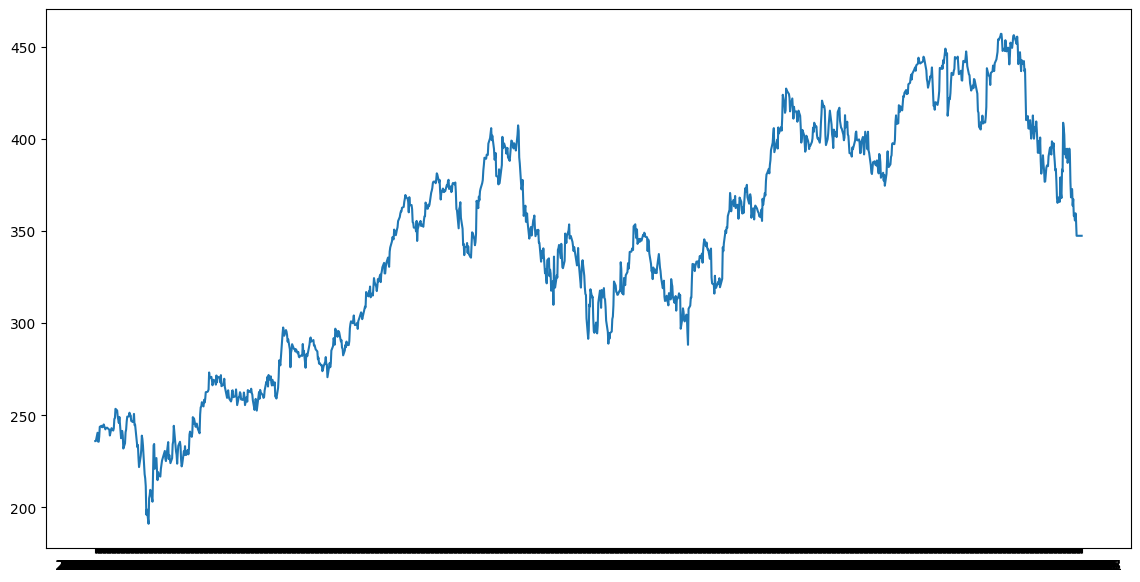

In [173]:
# Linear regression model

# Read csv file
merged_df = pd.read_csv('../Data/merged_data.csv')

# Create 30-day lag features(stockprice, currencyrate, indices)
lag_features = {}
for lag in range (1, 31):
    lag_features[f'Stock_Lag{lag}'] = merged_df['Close Stock Price'].shift(lag)
    lag_features[f'Currency_Lag{lag}'] = merged_df['Close Currency Rate'].shift(lag)
    lag_features[f'Sales_Lag{lag}'] = merged_df['Total_Sales_EUR_Million'].shift(lag)
    lag_features[f'EPS_Lag{lag}'] = merged_df['EPS'].shift(lag)
lag_df = pd.DataFrame(lag_features)
merged_df = pd.concat([merged_df, lag_df], axis=1)

# Drop records having null value from lagged-dataframe
merged_df.dropna(inplace=True)

# Define features and target
features = [f'Stock_Lag{lag}' for lag in range(1,31)] + \
           [f'Currency_Lag{lag}' for lag in range(1,31)] + \
           [f'Sales_Lag{lag}' for lag in range(1,31)] + \
           [f'EPS_Lag{lag}' for lag in range(1,31)]
target = 'Close Stock Price'

X = merged_df[features]
y = merged_df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = LinearRegression()
model.fit(X_train, y_train)

# Model prediction
y_pred = model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean-Squared Error: ", mse)
print("R-squared Score: ", r2)

# Predict the stock price for the next 30 days
last_row = merged_df.iloc[-1]
future_dates = pd.date_range(start=last_row['Date'], periods=30, freq='B')
future_data = pd.DataFrame(index=future_dates)

# Initialize future data with the last known values
for lag in range(1, 31):
    future_data[f'Stock_Lag{lag}'] = last_row[f'Stock_Lag{lag}']
    future_data[f'Currency_Lag{lag}'] = last_row[f'Currency_Lag{lag}']
    future_data[f'Sales_Lag{lag}'] = last_row[f'Sales_Lag{lag}']
    future_data[f'EPS_Lag{lag}'] = last_row[f'EPS_Lag{lag}']

# Predict future stock prices iteratively
future_predictions = []
for i in range(len(future_data)):
    prediction = model.predict(future_data.iloc[i].values.reshape(1, -1))
    future_predictions.append(prediction[0])
    if i + 1 < len(future_data):
        future_data.iloc[i + 1, :30] = future_data.iloc[i, :30].values
        future_data.iloc[i + 1, 30:60] = future_data.iloc[i, 30:60].values 
        future_data.iloc[i + 1, 60:90] = future_data.iloc[i, 60:90].values
        future_data.iloc[i + 1, 90:] = future_data.iloc[i, 90:].values
        future_data.iloc[i + 1, 0] = prediction[0]
# Add predictions to future data
future_data['Predicted Stock Price'] = future_predictions

# Print future predictions
print(future_data[['Predicted Stock Price']])

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(merged_df['Date'], merged_df['Close Stock Price'], label='Actual Stock Price') 
plt.plot(future_data.index, future_data['Predicted Stock Price'], label='Predicted Stock Price', linestyle='--') 
plt.xlabel('Date') 
plt.ylabel('Stock Price') 
plt.title('Stock Price Prediction for the Next 30 Days') 
plt.legend() 
plt.grid(True) 
plt.show()


print(merged_df)

        Date  Close Stock Price
0 2019-11-11         240.710312
1 2019-11-12         241.446991
2 2019-11-13         241.446991
3 2019-11-14         240.802383
4 2019-11-15         241.047948
                                Date  Close Stock Price
count                           1790        1790.000000
mean   2022-04-24 11:53:33.854748672         341.200971
min              2019-11-11 00:00:00         191.168549
25%              2021-01-31 06:00:00         288.586800
50%              2022-04-23 12:00:00         346.624450
75%              2023-07-14 18:00:00         395.379723
max              2024-11-11 00:00:00         456.899994
std                              NaN          64.429520
Number of NaN values in each column:
 Date                       0
Close Stock Price          0
Close Currency Rate        0
Total_Sales_EUR_Million    0
EPS                        0
dtype: int64
Date                       datetime64[ns]
Close Stock Price                 float64
Close Currency Rate     

C:\Users\abcam\AppData\Local\Temp\ipykernel_13052\1909580637.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future_data[f'Stock_Lag{lag}'] = last_row[f'Stock_Lag{lag}']
C:\Users\abcam\AppData\Local\Temp\ipykernel_13052\1909580637.py:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future_data[f'Currency_Lag{lag}'] = last_row[f'Currency_Lag{lag}']
C:\Users\abcam\AppData\Local\Temp\ipykernel_13052\1909580637.py:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

            Predicted Stock Price
2024-11-11           3.258622e+05
2024-11-12           6.545290e+05
2024-11-13           9.540063e+05
2024-11-14           1.233532e+06
2024-11-15           1.513428e+06
2024-11-18           1.780641e+06
2024-11-19           2.006314e+06
2024-11-20           2.208007e+06
2024-11-21           2.409324e+06
2024-11-22          -8.290415e+06
2024-11-25          -3.636602e+07
2024-11-26          -7.477895e+07
2024-11-27          -1.063838e+08
2024-11-28          -1.416875e+08
2024-11-29          -2.013373e+08
2024-12-02          -2.820684e+08
2024-12-03          -3.769704e+08
2024-12-04          -4.860155e+08
2024-12-05          -2.480768e+08
2024-12-06           1.134237e+09
2024-12-09           4.148370e+09
2024-12-10           7.912838e+09
2024-12-11           1.172793e+10
2024-12-12           1.730760e+10
2024-12-13           2.736018e+10
2024-12-16           4.231418e+10
2024-12-17           6.086380e+10
2024-12-18           7.143691e+10
2024-12-19    

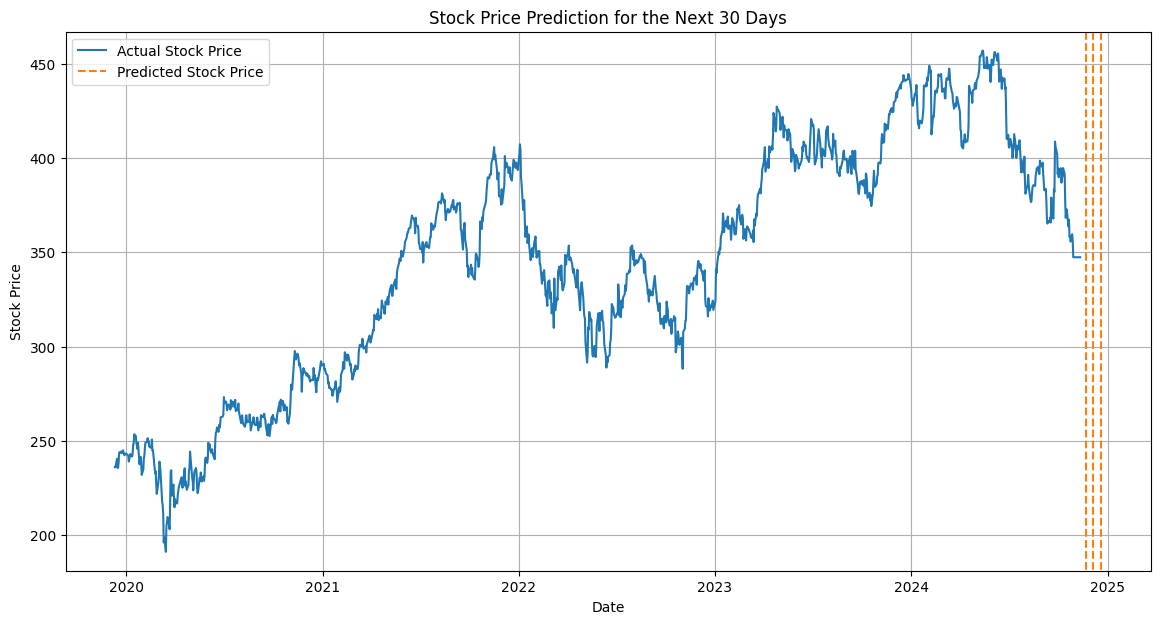

           Date  Close Stock Price
30   2019-12-11         236.013962
31   2019-12-12         236.013962
32   2019-12-13         237.518031
33   2019-12-14         239.022100
34   2019-12-15         240.526169
...         ...                ...
1785 2024-11-05         347.350006
1786 2024-11-06         347.350006
1787 2024-11-07         347.350006
1788 2024-11-08         347.350006
1789 2024-11-11         347.350006

[1760 rows x 2 columns]


In [185]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Load the merged data
merged_df = pd.read_csv('../Data/merged_data.csv')

# Convert the Date column to datetime format
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Print the first few rows of the DataFrame to verify the data
print(merged_df[['Date', 'Close Stock Price']].head())

# Print summary statistics to verify the data
print(merged_df[['Date', 'Close Stock Price']].describe())

# Check for NaN values in the entire DataFrame
print("Number of NaN values in each column:\n", merged_df.isna().sum())

# Check data types
print(merged_df.dtypes)

# Feature engineering: Create lag features for the past 30 days
lag_features = {}
for lag in range(1, 31):
    lag_features[f'Stock_Lag{lag}'] = merged_df['Close Stock Price'].shift(lag)
    lag_features[f'Currency_Lag{lag}'] = merged_df['Close Currency Rate'].shift(lag)
    lag_features[f'Sales_Lag{lag}'] = merged_df['Total_Sales_EUR_Million'].shift(lag)
    lag_features[f'EPS_Lag{lag}'] = merged_df['EPS'].shift(lag)

# Concatenate the lag features with the original DataFrame
lag_df = pd.DataFrame(lag_features)
merged_df = pd.concat([merged_df, lag_df], axis=1)

# Drop rows with NaN values resulting from lag features
merged_df.dropna(inplace=True)

# Define features and target
features = [f'Stock_Lag{lag}' for lag in range(1, 31)] + \
           [f'Currency_Lag{lag}' for lag in range(1, 31)] + \
           [f'Sales_Lag{lag}' for lag in range(1, 31)] + \
           [f'EPS_Lag{lag}' for lag in range(1, 31)]
target = 'Close Stock Price'

X = merged_df[features]
y = merged_df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = LinearRegression()
model.fit(X_train, y_train)

# Model prediction
y_pred = model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean-Squared Error: ", mse)
print("R-squared Score: ", r2)

# Predict the stock price for the next 30 days
last_row = merged_df.iloc[-1]
future_dates = pd.date_range(start=last_row['Date'], periods=30, freq='B')
future_data = pd.DataFrame(index=future_dates)

# Initialize future data with the last known values
for lag in range(1, 31):
    future_data[f'Stock_Lag{lag}'] = last_row[f'Stock_Lag{lag}']
    future_data[f'Currency_Lag{lag}'] = last_row[f'Currency_Lag{lag}']
    future_data[f'Sales_Lag{lag}'] = last_row[f'Sales_Lag{lag}']
    future_data[f'EPS_Lag{lag}'] = last_row[f'EPS_Lag{lag}']

# Predict future stock prices iteratively
future_predictions = []
for i in range(len(future_data)):
    prediction = model.predict(future_data.iloc[i].values.reshape(1, -1))
    future_predictions.append(prediction[0])
    if i + 1 < len(future_data):
        # Update the lag features for the next day
        for lag in range(30, 1, -1):
            future_data.iloc[i + 1, future_data.columns.get_loc(f'Stock_Lag{lag}')] = future_data.iloc[i, future_data.columns.get_loc(f'Stock_Lag{lag-1}')]
            future_data.iloc[i + 1, future_data.columns.get_loc(f'Currency_Lag{lag}')] = future_data.iloc[i, future_data.columns.get_loc(f'Currency_Lag{lag-1}')]
            future_data.iloc[i + 1, future_data.columns.get_loc(f'Sales_Lag{lag}')] = future_data.iloc[i, future_data.columns.get_loc(f'Sales_Lag{lag-1}')]
            future_data.iloc[i + 1, future_data.columns.get_loc(f'EPS_Lag{lag}')] = future_data.iloc[i, future_data.columns.get_loc(f'EPS_Lag{lag-1}')]

        # Update the stock price lag with the predicted value
        future_data.iloc[i + 1, future_data.columns.get_loc('Stock_Lag1')] = prediction[0]

# Add predictions to future_data
future_data['Predicted Stock Price'] = future_predictions

# Print future predictions
print(future_data[['Predicted Stock Price']])

# Plot the results with adjusted y-axis limits to reflect actual stock prices
plt.figure(figsize=(14, 7))
plt.plot(merged_df['Date'], merged_df['Close Stock Price'], label='Actual Stock Price')
plt.plot(future_data.index, future_data['Predicted Stock Price'], label='Predicted Stock Price', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction for the Next 30 Days')
plt.legend()
plt.grid(True)
plt.ylim([merged_df['Close Stock Price'].min() - 10, merged_df['Close Stock Price'].max() + 10]) # Adjust y-axis limits
plt.show()

# Print the merged DataFrame to check the Date column and Close Stock Price column
print(merged_df[['Date', 'Close Stock Price']])
